<a href="https://colab.research.google.com/github/avashs/Swarm-AI-Project/blob/main/SwarmAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

workspace for Swarm AI project

Enviorment Class

In [ ]:
import numpy
import random
from matplotlib import pyplot as plt
from matplotlib import colors

class World:
  map = numpy.zeros((10,10,3))           # [len, len, 3] true global map
  Wlen = 0           # length of one side of square global map
  numLandmarks = 0  # total number of landmarks to be randomly placed
  numRobots = 0     # total number of robots to add to the enviorment
  detectRange = 0   # detection (radius) range of the agents
  frames=[]         # 

  #constructor
  def __init__(self, length,numberRobots, detection):
    self.Wlen = length
    self.numRobots = numberRobots
    self.detectRange = detection
  #-----------------------------------------------------------------------------

 # generates a square map with a set number of robots and landmarks,
 #         plane 1 = robot locations with value of ID number of robot
 #         plane 2 = landmark locations with value of 1
 #         plane 3 = discoverd[1] vs undiscoved locations [0]
 # randomly places landmarks and robots

  def generateMap(self, numberRobots, numberLandmarks):
    self.numLandmarks = numberLandmarks
    self.map = np.zeros((self.Wlen,self.Wlen,3))
    mid =int(np.floor(self.Wlen /2))
    self.map[mid,mid,0] = 1;
    r = 2
    while r < self.numRobots+2:
      x = random.randrange(self.Wlen)
      y = random.randrange(self.Wlen)
      if self.map[x,y,ROBOTS] == 0: 
        self.map[x,y,ROBOTS] = r
        r+=1
    
    L = 0
    while L < self.numLandmarks:
      x = random.randrange(self.Wlen)
      y = random.randrange(self.Wlen)
      if self.map[x,y,LANDMARKS] == 0: 
        self.map[x,y,LANDMARKS] = 1
        L +=1
  #----------------------------------------------------------------------------- 

  # displays the map of the eviorment with the true values of what the agents   #
  # have seen and been
  # also records the images to save to a file, to play back as a video

  # black trianges = landmarks
  # red circles = agent
  # hot pink square = detection range of agents
  # blue diamond = base beacon
  def displayMap(self,i):
    
    agentsLocation = numpy.argwhere(self.map[: ,:,0] != 0) #find index location of agent 
    landmarkLocations = numpy.argwhere(self.map[: ,:,1] == 1) #find the location of landmark
    dislandmarkLocations = numpy.argwhere(self.map[: ,:,2] == 1) #find the discovered landmark
    x=agentsLocation[:,0]
    y=agentsLocation[:,1]
    xLan=landmarkLocations[:,0]
    yLan=landmarkLocations[:,1]
    dxLan=dislandmarkLocations[:,0]
    dyLan=dislandmarkLocations[:,1]

    fig = plt.figure(figsize=(self.Wlen,self.Wlen))
    plt.xlim(-1,self.Wlen)
    plt.xticks(range(0, self.Wlen))
    plt.yticks(range(0, self.Wlen))

    plt.ylim(-1,self.Wlen)
    plt.plot(x, y,'ro', markersize=12) # red circle for agents
    plt.scatter(x,y, s = 2*(self.detectRange)*10000, c= 'hotpink', marker = 's', alpha = 0.2)
    plt.grid()

    plt.plot(xLan, yLan,'k^',markersize=12) # landmark location
    plt.plot(dxLan, dyLan,'go', mfc='none') # places agent have travelled
    
    mid = int(np.floor(self.Wlen /2))
    plt.plot(mid, mid,'bD', markersize=20)
    filename='tes'+str(i)+'.png'
    plt.savefig(fname=filename, dpi=96)
    self.frames.append(imageio.imread(filename))

    plt.gca()
    plt.close(fig)
  #-----------------------------------------------------------------------------

  # moving the agent in the world (enviorment acting on agent)
  # ID = agent ID
  # dx = change in x index
  # dy = change in y index
  #
  # note: the agent is prevented from movint outside of the map
  #
  def updateAgentPos(self,ID,dx,dy):
    position = numpy.argwhere(self.map[: ,:,0] == ID) #find index location of agent 
    position = position[0]
    self.map[position[0],position[1],0] = 0 #erase old position from map
    newPose = [-1,-1]
    newPose[0] = position[0] + dx  #specify new location of agent
    newPose[1] = position[1] + dy

    if newPose[0] < 0:
      newPose[0] = 0
    if newPose[0] > self.Wlen-1:
      newPose[0] = self.Wlen -1

    if newPose[1] < 0:
      newPose[1] = 0
    if newPose[1] > self.Wlen-1:
      newPose[1] = self.Wlen -1
    
    if self.map[newPose[0],newPose[1],ROBOTS] != 0:
      newPose[0] = position[0]
      newPose[1] = position[1]
    
    self.map[newPose[0],newPose[1],0] = ID #update robot location in map
  #-----------------------------------------------------------------------------


  # returns the true position of the agent in the world (used for debugging purposees)
  def getTruePosition(self, ID):
    position = numpy.argwhere(self.map[: ,:,ROBOTS] == ID)
    return position
  #-------------------------------------------------------------------------------



Agent Class

In [ ]:
import numpy as np
import random
import imageio



class Agent:

  r = 0;                  #detection range, in cells
  ID = 0;                 #ID number of the robot
  position = [-1, -1]    # known location [x,y], is [-1,-1] if position is not known 
  Gmap = 0                # [len,len,3] global map known by the agent
  Lmap = 0               # [r,r,3] current obersvable enviorment
  mapLen = 0
  A = 1                 #Agressiveness factor 
  currVal = 0
  
  global ROBOTS 
  ROBOTS= 0             # constant for plane indexing
  global LANDMARKS
  LANDMARKS = 1          # constant for plane indexing
  global UNKNOWN 
  UNKNOWN = 2            # constant for plane indexing

  # initalizes the agent-------------------------------------------------------
  def __init__(self, ID, range, lengthMap):
    self.r = range
    self.ID = ID
    self.mapLen = lengthMap
    self.Gmap = np.zeros((lengthMap,lengthMap,3))
    self.Lmap = np.zeros((range,range,3))
    self.position = [-1,-1]        #initally does not know where it is
    self.A = random.randrange(100) #random agressiveness factor
    self.currVal = 0;
  #----------------------------------------------------------------------------- 

  # gets local map from the world (search for the id of the robot in the world
  # and grab the local map surrounding its pose)
  # is this getting local position of the agent?
  def getLocalMap(self, world):
    self.Lmap = -1*np.ones((2*self.r+1,2*self.r+1,3))
    position = numpy.argwhere(world.map[:,:,0] == self.ID)
    xRangeN=int(position[0][0] -(world.detectRange)) #starting position of detection range of the agent in x axis
    xRangeP=int(position[0][0] + (world.detectRange))+1#ending position of detection range of the agent in x axis
    yRangeN=int(position[0][1] - (world.detectRange))  #starting position of detection range of the agent in y axis
    yRangeP=int(position[0][1] + (world.detectRange))+1 #ending position of detection range of the agent in y axis
    
    length = len(self.Lmap[0])
    AxN = 0
    AxP = length
    AyN = 0
    AyP = length

    if xRangeN < 0:
      AxN = -1*xRangeN
    if xRangeP >= self.mapLen:
      AxP = length - (xRangeP - self.mapLen+1)+1

    if yRangeN < 0:
      AyN = -1*yRangeN
    if yRangeP >= self.mapLen:
      AyP = length - (yRangeP - self.mapLen+1)+1

    if xRangeN < 0:
      xRangeN = 0
    if xRangeP >= self.mapLen:
      xRangeP = self.mapLen

    if yRangeN < 0:
      yRangeN = 0
    if yRangeP >= self.mapLen:
      yRangeP = self.mapLen  

    lenx = xRangeP - xRangeN
    leny = yRangeP - yRangeN
    
    world.map[xRangeN:xRangeP, yRangeN:yRangeP, 2] = np.ones((lenx,leny))

    self.Lmap[AxN:AxP, AyN:AyP, :] = world.map[xRangeN:xRangeP, yRangeN:yRangeP, :] #Lmap of the agent with detection range
  #---------------------------------------------------------------------------------

  # update the global map, with an input map of any size, centered at [x,y]
  # this will be used to communicate with other agents and to paste the local map
  # view into the global map
  def updateGmap(self, Amap, x,y):
    
    length = len(Amap[0])
    xRangeN = int(x - numpy.floor(length/2))
    xRangeP = int(x + numpy.floor(length/2) + 1)
    yRangeN = int(y - numpy.floor(length/2))
    yRangeP = int(y + numpy.floor(length/2) +1)

    AxN = 0
    AxP = length
    AyN = 0
    AyP = length

    if xRangeN < 0:
      AxN = -1*xRangeN
    if xRangeP > self.mapLen:
      AxP = length - (xRangeP - self.mapLen+1)+1

    if yRangeN < 0:
      AyN = -1*yRangeN
    if yRangeP > self.mapLen:
      AyP = length - (yRangeP - self.mapLen+1)+1

    if xRangeN < 0:
      xRangeN = 0
    if xRangeP > self.mapLen:
      xRangeP = self.mapLen

    if yRangeN < 0:
      yRangeN = 0
    if yRangeP > self.mapLen:
      yRangeP = self.mapLen  

    self.Gmap[xRangeN:xRangeP, yRangeN:yRangeP,:] = Amap[AxN:AxP, AyN:AyP, :]
  #----------------------------------------------------------------------------

  # decision framework that determines how the agent will move
  # returns the change in x (dx) and change in y (dy) of the robot each can be
  # either [-1,0,1] all in global coordinate frame directions
  def move(self):
    xlen = len(self.Lmap)
    ylen = len(self.Lmap[0])
    mid = self.r
    Force = [0,0]

    # look in local world for landmarks and other agents
    # and then calcualate resultant artifical force
    for x in range(xlen):
      for y in range(ylen):
        if self.Lmap[x, y, ROBOTS] != 0 and self.Lmap[x,y,ROBOTS] != self.ID and self.Lmap[x,y,ROBOTS] != -1:
          dx = x - mid
          dy = y - mid
          d = numpy.sqrt((dx*dx) + (dy*dy))
          if d != 0:
            Force[0] = Force[0] - self.A*(1/d)*(dx/d) #update cost function
            Force[1] = Force[1] - self.A*(1/d)*(dy/d) #update cost function
        
        if (self.Lmap[x,y,LANDMARKS] == 1):
          dx = x - mid
          dy = y - mid
          d = numpy.sqrt((dx*dx) + (dy*dy))
          if d != 0:
            Force[0] = Force[0] + self.A*(1/d)*(dx/d) #update cost function
            Force[1] = Force[1] + self.A*(1/d)*(dy/d) #update cost function
    
    #discritize force to give dx and dy movement
    rdx = 0
    rdy = 0
    if (Force[0] != 0):
      rdx = round(Force[0]/numpy.abs(Force[0]))
    if (Force[1] != 0):
      rdy = round(Force[1]/numpy.abs(Force[1]))

    #if no force is large enough to cause movement take random motion
    if (rdx == 0 & rdy == 0):
      rdy = random.randrange(2) - 1
      rdx = random.randrange(2) - 1
    return rdx, rdy
  #-----------------------------------------------------------------------------


  #agent is at center of self localMap - 5x5 matrix will be at index 3x3 (or starting at 0, will be at 2x2)
  #scan localMap for agents and find their position (either x,y or -1,-1)
  #if they know their location, update agent's position; else don't do anything 
  #when they know their location, calculate the relative distance based of their location  
  def communicate(self, agents):
    mid = self.r
    Lside = len(self.Lmap[0])

    #look through the local map to find other agents
    for x in range(Lside):
      for y in range(Lside):
        val = int(round(self.Lmap[x,y,ROBOTS]))
        if val > 0 and val != self.ID:
          
          # localize self and other agent
          ind = int(val - 1)
          dx = x - mid
          dy = y - mid
          if (self.position[0] != -1):
            agents[ind].position[0] = self.position[0] + dx
            agents[ind].position[1] = self.position[1] + dy
          if (agents[ind].position[0] != -1):
            self.position[0] = agents[ind].position[0] - dx
            self.position[1] = agents[ind].position[1] - dy
          
          #communicate global map to each other
          for i in range(self.mapLen):
            for j in range(self.mapLen):
              #get/give global map information for landmarks
              if self.Gmap[i,j,LANDMARKS] == 1 or agents[ind].Gmap[i,j,LANDMARKS] == 1:
                self.Gmap[i,j,LANDMARKS] = 1
                agents[ind].Gmap[i,j,LANDMARKS] = 1
              #get/give global map information for Found locations
              if self.Gmap[i,j,UNKNOWN] == 1 or agents[ind].Gmap[i,j,UNKNOWN] == 1:
                self.Gmap[i,j,UNKNOWN] = 1
                agents[ind].Gmap[i,j,UNKNOWN] = 1
         
          #compare agressivness factors and update based on which agent is performing better
          totVal = agents[ind].currVal + self.currVal
          if totVal != 0:
            wo = agents[ind].currVal / totVal
            ws = self.currVal / totVal
            if self.currVal > agents[ind].currVal:
              agents[ind].A = ws*self.A + wo*agents[ind].A
            elif agents[ind].currVal > self.currVal:
              self.A = wo*agents[ind].A + ws*self.A
            
    
        val = []
#--------------------------------------------------------------------------------------------        
          
  # evaluates the how each agent did (mainly used for the base beacon case)
  # parameters: number of agents, size of area, number of landmarks
  # rewards: higher % expolored is better, more  % landmarks is better
  def evaluate(self, World):

  
    numLandMarks = World.numLandmarks 
    numRobots = World.numRobots
    length = World.Wlen
    dimensions = length * length  #area of world
    detecRange = self.r * self.r  #dection range area
    foundLM = 0 
    areaCovered = 0
    EfoundLM = 0      #landmarks seen in the world
    EareaCovered = 0  #area covered in the world

    for x in range(0,length):
      for y in range(0,length):
        if (self.Gmap[x,y,LANDMARKS] == 1 ):
          foundLM += 1
        if self.Gmap[x,y,UNKNOWN] == 1:
          areaCovered +=1
        if (World.map[x,y,LANDMARKS] == 1 and World.map[x,y,UNKNOWN] == 1):
          EfoundLM += 1
        if World.map[x,y,UNKNOWN] == 1:
          EareaCovered +=1


    percentLM = foundLM / numLandMarks
    percentAreaCovered = areaCovered / dimensions
    value = (percentAreaCovered * percentLM/numRobots)/ detecRange
    

    EpercentLM = EfoundLM / numLandMarks
    EpercentAreaCovered = EareaCovered / dimensions
    Evalue = (EpercentAreaCovered * EpercentLM /numRobots)/ detecRange 
    
    #evaluates the effectiveness of the communication rate of the agent by
    #comparing the amount of landmarks and covered area reported to the base beacon
    #by the total seen in the enviorment
    commsLM = 0
    commsAC = 0
    if EpercentLM != 0:
      commsLM = percentLM/EpercentLM 
    if EpercentAreaCovered != 0:
      commsAC =  percentAreaCovered/EpercentAreaCovered

    return value, percentLM, percentAreaCovered, commsLM, commsAC
  
  #----------------------------------------------------------------------------
  # displays the global information that the agent knows about
  def disMap(self):
    
    agentsLocation = numpy.argwhere(self.Gmap[: ,:,0] != 0) #find index location of agent 
    landmarkLocations = numpy.argwhere(self.Gmap[: ,:,1] == 1) #find the location of landmark
    dislandmarkLocations = numpy.argwhere(self.Gmap[: ,:,2] == 1) #find the discovered landmark
    x=agentsLocation[:,0]
    y=agentsLocation[:,1]
    xLan=landmarkLocations[:,0]
    yLan=landmarkLocations[:,1]
    dxLan=dislandmarkLocations[:,0]
    dyLan=dislandmarkLocations[:,1]

    fig = plt.figure(figsize=(self.mapLen,self.mapLen))
    plt.xlim(-1,self.mapLen)
    plt.xticks(range(0, self.mapLen))
    plt.yticks(range(0, self.mapLen))
    fig.patch.set_facecolor('xkcd:mint green')

    plt.ylim(-1,self.mapLen)
    plt.plot(x, y,'ro', markersize=12) # red circle for agents
    plt.scatter(x,y, s = 2*(self.r)*10000, c= 'hotpink', marker = 's', alpha = 0.2)
    plt.grid()

    plt.plot(xLan, yLan,'k^',markersize=12) # landmark location
    plt.plot(dxLan, dyLan,'go', mfc='none') # places we have been
    
    mid = int(np.floor(self.mapLen /2))
    plt.plot(mid, mid,'bD', markersize=20)
  
  # uses a heuristic function to evaluate how the agent is doing----------------
  def evaluateOnline(self):

    length = self.mapLen
    dimensions = length * length
    detecRange = self.r * self.r 
    foundLM = 0 
    areaCovered = 0

    for x in range(0,length):
      for y in range(0,length):
        if (self.Gmap[x,y,LANDMARKS] == 1 ):
          foundLM += 1
        if self.Gmap[x,y,UNKNOWN] == 1:
          areaCovered +=1


    percentAreaCovered = areaCovered / dimensions
    value =  foundLM * percentAreaCovered
    return value
  #-----------------------------------------------------------------------------

Training / Evaluation Functions

In [ ]:

def swarmSLAM(globalWorld, agents, maxT, threshold):
  
  #for a set time move agents and update their maps and the base beacon's map
  time = maxT;

  for t in range(time):
    for a in agents:
      a.getLocalMap(globalWorld) # 1) percieve your enviorment
      a.communicate(agents) # 2) talk to other agents (localize and share global map)
      if a.position[0] != -1:   #3) if you know were you are update your map
        a.updateGmap(a.Lmap, a.position[0], a.position[1])
      if a.ID != 1: #4) move if you are not the base 
        [dx,dy] = a.move()
        globalWorld.updateAgentPos(a.ID,dx,dy) #4.1) have world update your position
        a.getLocalMap(globalWorld)  #4.2) percieve your new world
        a.position = [-1,-1]              #4.3) forget where you are
      a.communicate(agents)               #4.4) ask were you are
      a.evaluateOnline() #evaluate the agents own performance online
    [V, LM, AC, commsLM, commsAC] = agents[0].evaluate(globalWorld)
    V = V/(t+1)
    if AC > threshold:
      return [V, LM, AC, commsLM, commsAC]

  return [V, LM, AC, commsLM, commsAC]    
      
  

# evaluate(maxWL, maxNL, maxNR, maxDR, maxT, itterations, threshold)
#   maxWL = 25, maximum world side length
#   maxNL = 30, maximum number of landmarks
#   maxDR = 10, maximum detection range of each robot
#   maxT = 100, maximum number of timesteps agents are allowed in the world
#   itterations = 1000, total number of randomly generated enviorments to test on
#   threshold = .95, minimum percentage of covered area needed to end test before time runs out
#
#
#  note: that the exact values of the maximum lengths may be altered to ensure that
#        no errors occure. AKA, dection range must be smaller than the world
#        must have less landmarks or robots than the total number of avaible spaces
#
#  at the end plots the distribution of the results of the itterations
#   - evaluation function value
#   - percentage of landmarks found
#   - percentage of area covered
#
def evaluate(maxWL, maxNL, maxNR, maxDR, maxT, itterations, threshold):
  VALUES = []
  PERCENT_LANDMARKS = []
  PERCENT_AREA_COVERED = []

  #loop for each test
  for itter in range(itterations):
    #generate enviorment
    length = random.randrange(maxWL)+ maxDR+1
    detection = random.randrange(maxDR)+1

    numberLandmarks =  random.randrange(maxNL)
    while numberLandmarks > length*length and numberLandmarks < 1:
      numberLandmarks = random.randrange(maxNL)+2
    
    numberRobots = random.randrange(maxNR)
    while numberRobots > length*length and numberRobots < 1:
      numberRobots = random.randrange(maxNR) + 2

    numberRobots += 1
    numberLandmarks += 1
    # print test conditions and itteration number
    print("ITTERATION NUMBER:             ", itter)
    print("length of world: ", length)
    print("detection range: ", detection)
    print("number of Landmarks: ", numberLandmarks)
    print("number of Robots: ", numberRobots)
    print("===================================================================")


    #generate global world
    globalWorld = World(length,numberRobots, detection)
    globalWorld.generateMap(numberRobots, numberLandmarks)
    
    #generate agents
    agents = []
    for i in range(numberRobots+1):
      agents.append(Agent(i+1, detection, length))
    for a in agents:
      a.getLocalMap(globalWorld)
      a.position = [-1,-1]
    x0 = np.floor(length/2)
    y0 = x0
    agents[0].position = [x0,y0]

    [V, LM, AC, commsLM, commsAC] = swarmSLAM(globalWorld, agents, maxT, threshold)
   
    VALUES.append(V)
    PERCENT_LANDMARKS.append(LM)
    PERCENT_AREA_COVERED.append(AC)

  #plot the value, percent landmarks discovered, and percent area covered 
  plt.figure()
  plt.hist(VALUES, density=False, bins=50)  # density=False would make counts
  plt.ylabel('counts')
  plt.xlabel('Value distribution');

  plt.figure()
  plt.hist(PERCENT_LANDMARKS, density=False, bins=50)  # density=False would make counts
  plt.ylabel('counts')
  plt.xlabel('Percentage of Landmarks found distribution');
  
  plt.figure()
  plt.hist(PERCENT_AREA_COVERED, density=False, bins=50)  # density=False would make counts
  plt.ylabel('counts')
  plt.xlabel('Percentage of Area Covered distribution');
  


  
# displays the results of an individual test, 
# 
# NOTE: this function is not called in the large batch evaluation case to limit output
#
# 1) displays the landmark and Known map of the Base Beacon agent
# 2) then displays the indepth evaluation of the AI
#    - percentage of total landmarks the base is aware of
#    - percentage of landmarks observed in the enviorment that were reported back to the base
#    - percentage of the total area covered that is known by the Base
#    - percentage of total enviorment observed by the agents that were reported back to the base
#    - the total value given by the evaluation function (THIS IS THE TRUE FINAL METRIC OF THE AI)
#
# 3) then displays how each individual agent did on average
#    - repeats the same printout as above witht the average agent value
#    - with the adition of the agressiveness distribution of al the agents

#   globalWorld = Enviorment Class object
#   agents = vector of Agent Class objects
#
def printResults(globalWorld, agents):
  [V, LM, AC, commsLM, commsAC] = agents[0].evaluate(globalWorld)
  print("BASE BEACON    ####################################################")
  print("map is displayed at the end")
  agents[0].disMap()
  print("Percent of landmarks discovered by base")
  print(round(LM*100))
  print("Percent of found landmarks communicated back to base")
  print(round(commsLM*100))
  print("Percent of area covered dicovered by base")
  print(round(AC*100))
  print("Percent of found area covered communicated back to base")
  print(round(commsAC*100))
 
  print("Total Value")
  print(round(V*100))

  #calculate the average values of each agent
  totalV = 0;
  totalLM = 0;
  totalAC = 0;
  totalcLM = 0;
  totalcAC = 0;
  agressivness = []
  for a in agents:
    [V, LM, AC, commsLM, commsAC] = a.evaluate(globalWorld)
    totalV += V
    totalLM += LM
    totalAC += AC
    totalcLM += commsLM
    totalcAC += commsAC
    agressivness.append(a.A)
 
  #plot the learned agressiveness distribution of all the agents
  plt.figure()
  plt.hist(agressivness, density=False, bins=30) 
  plt.ylabel('counts')
  plt.xlabel('Agressivness factor');

  avgV = totalV / (globalWorld.numRobots +1)
  avgLM = totalLM / (globalWorld.numRobots+1)
  avgAC = totalAC / (globalWorld.numRobots+1)
  avgcLM = totalcLM / (globalWorld.numRobots+1)
  avgcAC = totalcAC / (globalWorld.numRobots+1)

  print("Average Robot Evaluation  ###########################################")
  print("Percent of landmarks discovered by this robot")
  print(round(avgLM*100))
  print("Percent of area covered by this robot")
  print(round(avgAC*100))
  print("Percent of found landmarks discovered or communicated by this robot")
  print(round(avgcLM*100))
  print("Percent of found area covered or communicated by this robot")
  print(round(avgcAC*100))

  print("Total Value")
  print(round(avgV*100))

MAIN SCRIPT

ITTERATION NUMBER:              0
length of world:  29
detection range:  2
number of Landmarks:  19
number of Robots:  97
ITTERATION NUMBER:              1
length of world:  33
detection range:  5
number of Landmarks:  19
number of Robots:  45
ITTERATION NUMBER:              2
length of world:  33
detection range:  8
number of Landmarks:  25
number of Robots:  9
ITTERATION NUMBER:              3
length of world:  32
detection range:  1
number of Landmarks:  18
number of Robots:  73
ITTERATION NUMBER:              4
length of world:  33
detection range:  5
number of Landmarks:  6
number of Robots:  48
ITTERATION NUMBER:              5
length of world:  26
detection range:  8
number of Landmarks:  8
number of Robots:  77
ITTERATION NUMBER:              6
length of world:  18
detection range:  8
number of Landmarks:  17
number of Robots:  77
ITTERATION NUMBER:              7
length of world:  27
detection range:  4
number of Landmarks:  27
number of Robots:  41
ITTERATION NUMBER:         

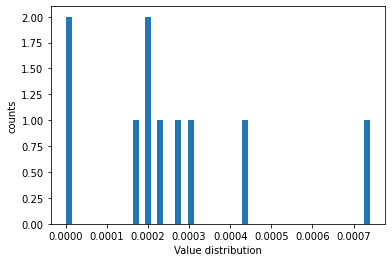

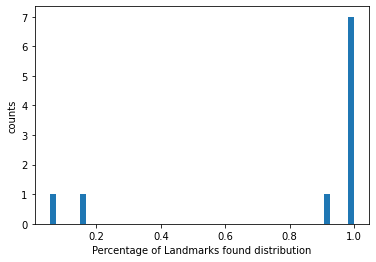

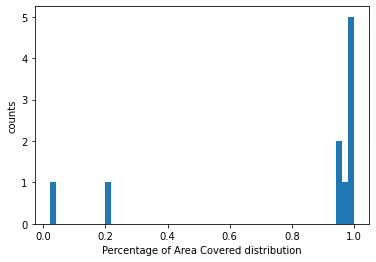

In [ ]:
# evaluate(maxWL, maxNL, maxNR, maxDR, maxT, itterations, threshold)
#   maxWL = 25, maximum world side length
#   maxNL = 30, maximum number of landmarks
#   maxDR = 10, maximum detection range of each robot
#   maxT = 100, maximum number of timesteps agents are allowed in the world
#   itterations = 100, total number of randomly generated enviorments to test on
#   threshold = .95, minimum percentage of covered area needed to end test before time runs out

evaluate(25,30,100, 10, 100, 10, .95)



Test on user specified world

BASE BEACON    ####################################################
map is displayed at the end
Percent of landmarks discovered by base
67
Percent of found landmarks communicated back to base
67
Percent of area covered dicovered by base
57
Percent of found area covered communicated back to base
77
Total Value
5
Average Robot Evaluation  ###########################################
Percent of landmarks discovered by this robot
78
Percent of area covered by this robot
59
Percent of found landmarks discovered or communicated by this robot
78
Percent of found area covered or communicated by this robot
80
Total Value
6


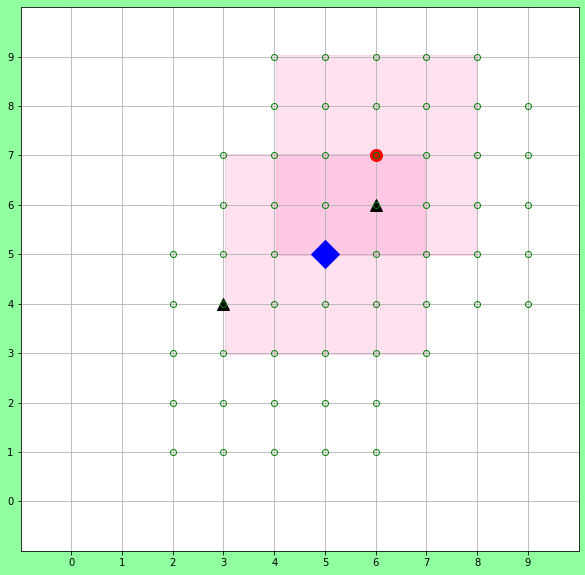

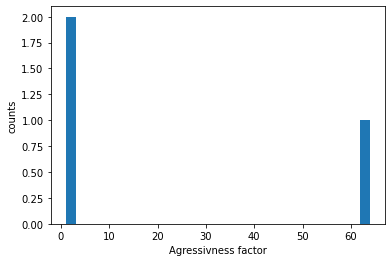

In [ ]:
ROBOT = 0    #robot plane of the map
LANDMARK = 1 #landmark plane of the map

#please specify a global world
worldLength = 10
numberRobots = 2
detectionRadius = 2
numberlandmarks = 3
maxTimeInWorld = 100
threshold = .95 #minium percent of area covered to quit before time runs out

#crates a world object----------------------------------------------------------
globalWorld = World(worldLength,numberRobots, detectionRadius)
globalWorld.numLandmarks = numberlandmarks
globalWorld.map = numpy.zeros((worldLength,worldLength,3))

#please specify the location of all the robots, base beacon, and landmarks
#   note: the robot plane of the map = 0
#         the Landmark plane of the map = 1

#place base beacon at [x = 5, y = 5]
BaseBeaconX = 5
BaseBeaconY = 5
globalWorld.map[BaseBeaconX,BaseBeaconY,ROBOT] = 1 # the 1 is the agent ID number 
                               # and specifically 1 is reserved for the base beacon

#place robots
globalWorld.map[7,6,ROBOT] = 2 #place robot at [7,6] with the next ID 2
globalWorld.map[4,3,ROBOT] = 3 #place robot at [4,3] with the next ID 3

#place Landmarks
globalWorld.map[6,6,LANDMARK] = 1 #place a landmark at [6,6]
globalWorld.map[3,4, LANDMARK] = 1 #place a landmark at [3,4]
globalWorld.map[1,2, LANDMARK] = 1 #place a landmark at [1,2]

#-------------------------------------------------------------------------------

#create agents
agents = []
for i in range(numberRobots+1):
  agents.append(Agent(i+1, detectionRadius, worldLength))
for a in agents:
  a.getLocalMap(globalWorld)
  a.position = [-1,-1]
 
  agents[0].position = [BaseBeaconX,BaseBeaconY]
#-------------------------------------------------------------------------------

# run AI
swarmSLAM(globalWorld, agents, maxTimeInWorld, threshold)

#print the results
printResults(globalWorld, agents)
